# Noise-As-Clean Experiment

[Europe PMC: Noisy-As-Clean: Learning Self-supervised Denoising from Corrupted Image](https://europepmc.org/article/med/32997627)

Key idea: 
- **Noise-As-CLean**: Using noisy image as both input and target
- **Generalization to Clean Images**: Even though trained with noisy images as target, the network, when presented with a real-world noisy image, generalizes to produce a denoised version, leveraging the structured noise learning.

Pros: 
1. **Simplicity**: There's no need for paired noisy-clean datasets. This can significantly simplify the data collection and pre-processing steps.
2. **Effectiveness**: In many scenarios, NAC has been found to perform comparably, or sometimes even better than traditional denoising methods, especially when there's a lack of ground-truth clean images.
3. **Robustness**: Training on various noise patterns might offer more robustness against different noise types.

Cons:
1. **Potential Overfitting**: If not implemented carefully, there's a risk that the network might overfit to the specific noise patterns of the training dataset, leading to less optimal performance on real-world or unseen noise distributions.
2. **Dependence on Noise Type**: The success of NAC might depend on the type and distribution of noise in the training data. It might not generalize well for all types of noises or for extremely high levels of noise.

In [1]:
import os
import copy
import json
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data

from module.models import UNet2_5D, ResNet34_UNet
from module.datasets import NACDataset
from module.loss import SSIMLoss, SSIM_MAELoss, SSIM_MSELoss

import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


## Load preprocessed data

Noisy data...float32 (shape:(11, 24, 71, 192, 192); range:[0.0,1.0]; mean:0.4568054974079132); std:0.023385096341371536
{'original_min': -32768.0, 'original_max': 32767.0, 'z_score_mean': 201.4710693359375, 'z_score_std_dev': 1407.2664794921875, 'noise_min': -23.428024291992188, 'noise_max': 28.94860076904297}


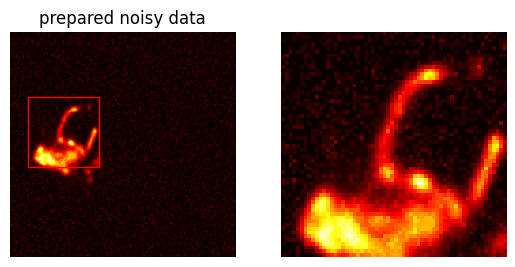

In [2]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_poisson_0.50_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

display_image_in_detail(noisy_data[0, 11, 38], title="prepared noisy data")

## Process Denoising

## 1. import denoising network

In [3]:
model = UNet2_5D(in_channels=3, out_channels=1)

#model = ResNet34_UNet(in_channels=3, out_channels=1)

model = model.to(device)
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

summary(model, [(1, 192, 192), (1, 192, 192), (1, 192, 192)])

The number of parameters of the network is:  138372097
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           1,792
       BatchNorm2d-2         [-1, 64, 192, 192]             128
         LeakyReLU-3         [-1, 64, 192, 192]               0
            Conv2d-4         [-1, 64, 192, 192]          36,928
       BatchNorm2d-5         [-1, 64, 192, 192]             128
            Conv2d-6         [-1, 64, 192, 192]             256
         LeakyReLU-7         [-1, 64, 192, 192]               0
         UNetBlock-8         [-1, 64, 192, 192]               0
         MaxPool2d-9           [-1, 64, 96, 96]               0
           Conv2d-10          [-1, 128, 96, 96]          73,856
      BatchNorm2d-11          [-1, 128, 96, 96]             256
        LeakyReLU-12          [-1, 128, 96, 96]               0
           Conv2d-13          [-1, 128, 96, 96] 

## 2. create NAC dataset and dataloader

In [4]:
# def split_tensor(data_tensor):
#     """split tensor into train, test, vali tensor

#     Args:
#         data_tensor (_type_): _description_

#     Returns:
#         _type_: _description_
#     """
#     test_tensor = data_tensor[0:1]
    
#     rest_tensor = data_tensor[1:]

#     total_samples = rest_tensor.shape[0]
    
#     train_ration = 0.8
#     train_length = int(train_ration * total_samples)
#     val_length = total_samples - train_length
    
    
#     train_subset, val_subset = random_split(rest_tensor, [train_length, val_length])
    
    
#     # Convert Subset back into tensors
#     train_tensor = train_subset.dataset[train_subset.indices]
#     val_tensor = val_subset.dataset[val_subset.indices]

#     return train_tensor, val_tensor, test_tensor


def split_data(data_array):
    """split ndarray into train, test, vali arrays

    Args:
        data_array (numpy.ndarray): The input data array.

    Returns:
        numpy.ndarray, numpy.ndarray, numpy.ndarray: Train, Validation, Test arrays.
    """
    test_array = data_array[0:1]
    rest_array = data_array[1:]

    total_samples = rest_array.shape[0]
    
    train_ration = 0.8
    train_length = int(train_ration * total_samples)
    val_length = total_samples - train_length
    
    indices = np.arange(total_samples)
    np.random.shuffle(indices)

    train_array = rest_array[indices[:train_length]]
    val_array = rest_array[indices[train_length:]]

    return train_array, val_array, test_array

In [5]:
## split ndarray data
train_data, val_data, test_data = split_data(noisy_data)


## add channel dim
train_tensor = torch.tensor(train_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
val_tensor = torch.tensor(val_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
test_tensor = torch.tensor(test_data[..., np.newaxis, :, :, :], dtype=torch.float32) 

print(f"train_tensor:\n {train_tensor.dtype}; shape:{train_tensor.shape}; range:({torch.min(train_tensor)},{torch.max(train_tensor)}); mean:{torch.mean(train_tensor)}; std:{torch.std(train_tensor)}")
print(f"val_tensor:\n {val_tensor.dtype}; shape:{val_tensor.shape}; range:({torch.min(val_tensor)},{torch.max(val_tensor)}); mean:{torch.mean(val_tensor)}; std:{torch.std(val_tensor)}")
print(f"test_tensor:\n {test_tensor.dtype}; shape:{test_tensor.shape}; range:({torch.min(test_tensor)},{torch.max(test_tensor)}); mean:{torch.mean(test_tensor)}; std:{torch.std(test_tensor)}")


## create dataset
train_dataset = NACDataset(train_tensor, mode='train', noise_type="poisson")
val_dataset = NACDataset(val_tensor, mode='train', noise_type="poisson")
test_dataset = NACDataset(test_tensor, noise_type="poisson")

print(f"train_dataset: {len(train_dataset)}")
print(f"val_dataset: {len(val_dataset)}")
print(f"test_dataset: {len(test_dataset)}")


# create dataloader
batch_size = 16
num_workers = 12

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_tensor:
 torch.float32; shape:torch.Size([8, 24, 1, 71, 192, 192]); range:(0.0,1.0); mean:0.4568489193916321; std:0.023392396047711372
val_tensor:
 torch.float32; shape:torch.Size([2, 24, 1, 71, 192, 192]); range:(0.0,0.9845805764198303); mean:0.4568340480327606; std:0.02332828938961029
test_tensor:
 torch.float32; shape:torch.Size([1, 24, 1, 71, 192, 192]); range:(1.358317877020454e-05,0.965488076210022); mean:0.4568372368812561; std:0.023439105600118637
train_dataset: 13248
val_dataset: 3312
test_dataset: 1656


Batch 1
top_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9862844944000244,0.12625107169151306); mean:0.45722395181655884; std:0.02931145764887333
middle_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9808596968650818,0.03052680753171444); mean:0.45694318413734436; std:0.028622733429074287
bottom_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9868162274360657,0.05768880993127823); mean:0.456792950630188; std:0.02830994687974453
middle_target: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9320687651634216,0.03306298702955246); mean:0.456970751285553; std:0.023640381172299385


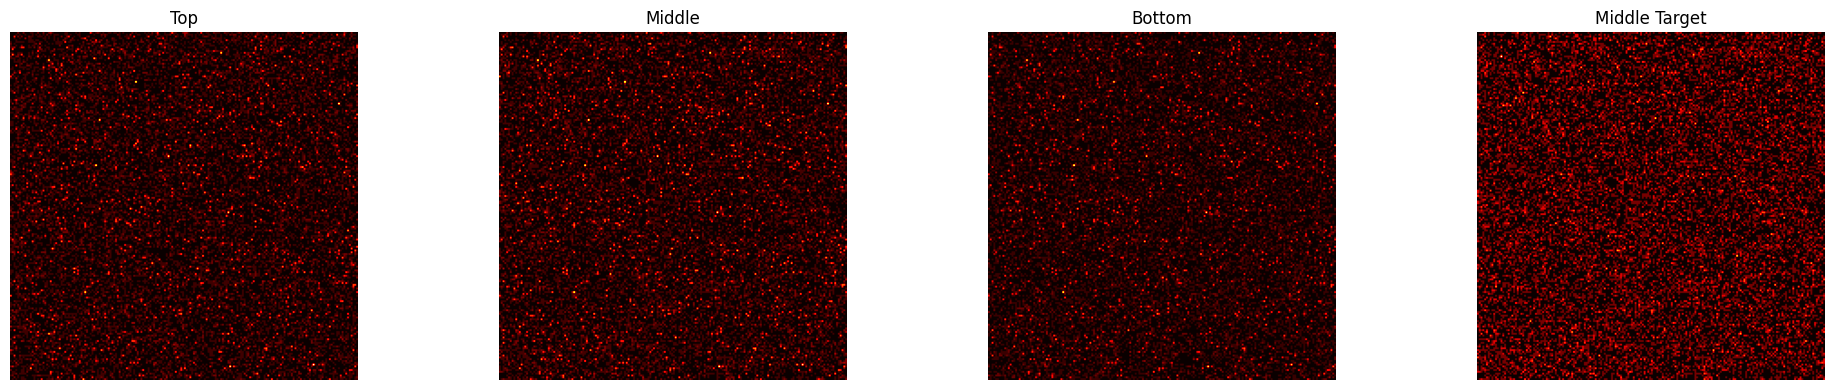

Batch 2
top_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.986260712146759,0.2868543863296509); mean:0.45608124136924744; std:0.024863403290510178
middle_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9572172164916992,0.3280982971191406); mean:0.45611000061035156; std:0.025052392855286598
bottom_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.983750581741333,0.10981764644384384); mean:0.45612797141075134; std:0.024668768048286438
middle_target: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.92730313539505,0.3307245671749115); mean:0.45610517263412476; std:0.019258718937635422


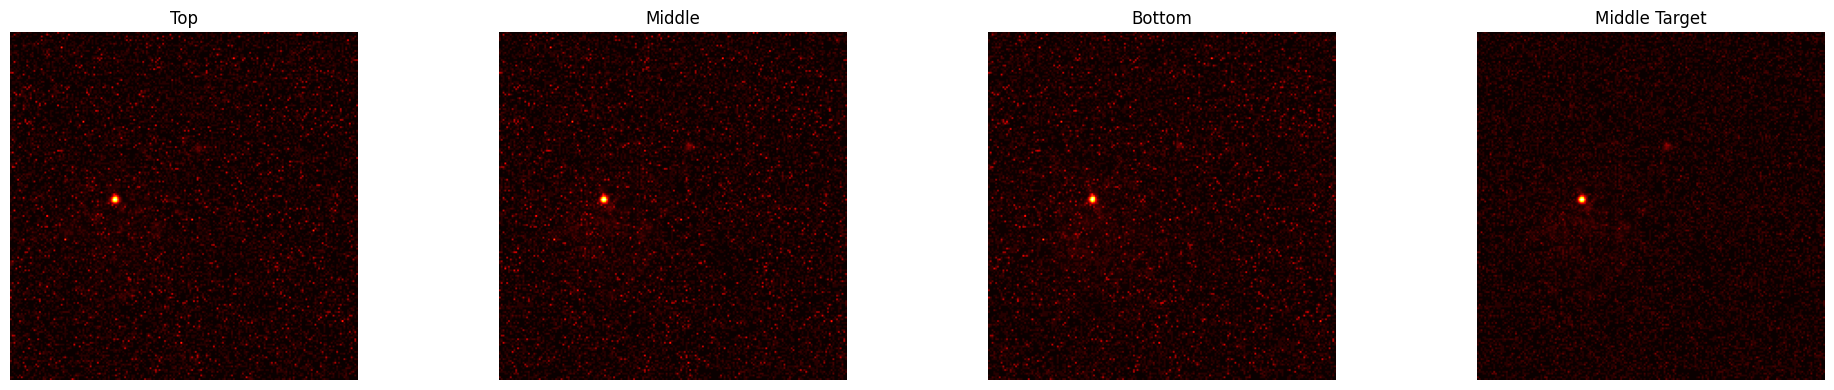

Batch 3
top_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9787401556968689,-0.002471210202202201); mean:0.4555339813232422; std:0.024458223953843117
middle_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9838142991065979,0.3691549003124237); mean:0.45561742782592773; std:0.02470136433839798
bottom_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9865683913230896,0.38303402066230774); mean:0.4555744528770447; std:0.024436596781015396
middle_target: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9154455065727234,0.3717649579048157); mean:0.4555932283401489; std:0.018848303705453873


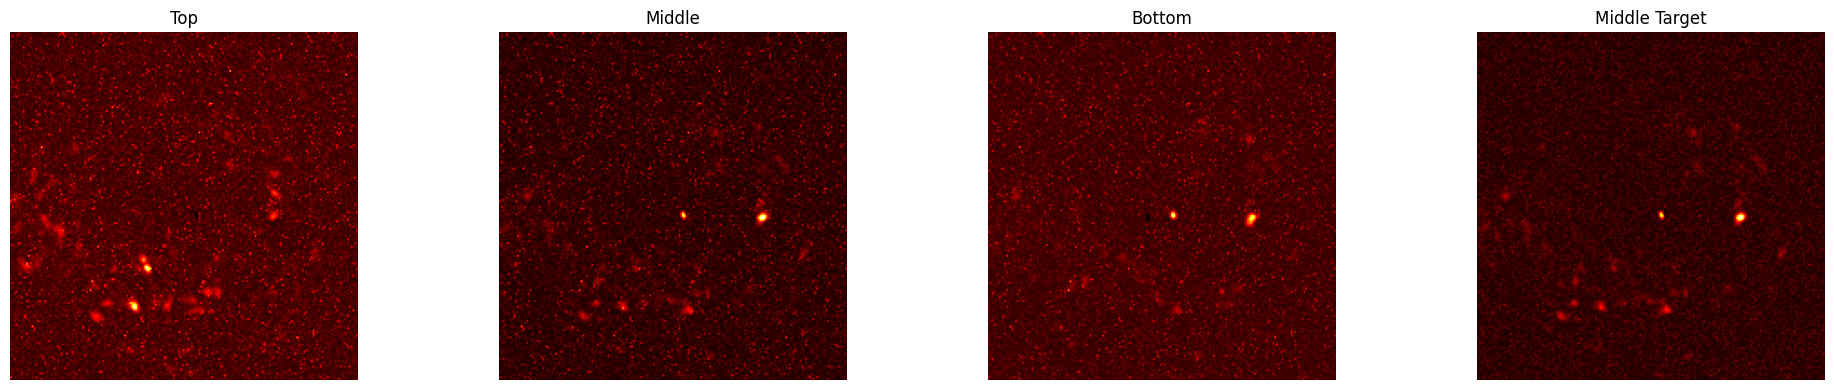

Batch 4
top_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9705657958984375,0.20781682431697845); mean:0.45705780386924744; std:0.02790132537484169
middle_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9328458905220032,0.011718375608325005); mean:0.45690006017684937; std:0.02771812304854393
bottom_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9936160445213318,0.11230465024709702); mean:0.45710018277168274; std:0.027945557609200478
middle_target: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9354333877563477,0.014245476573705673); mean:0.45690515637397766; std:0.022585054859519005


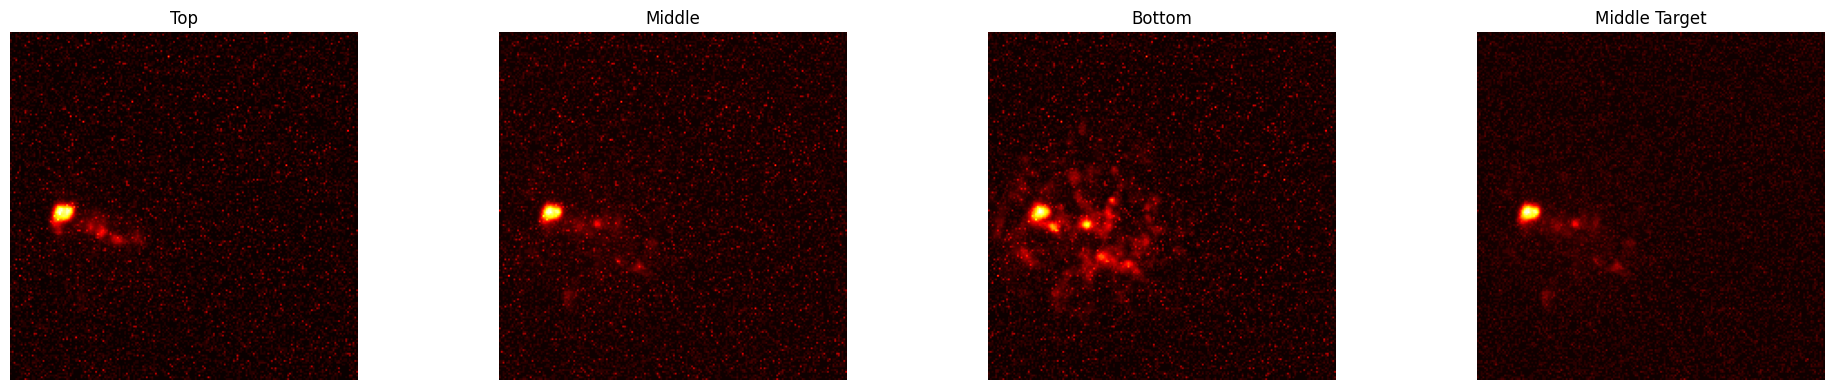

Batch 5
top_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9812076091766357,0.14629656076431274); mean:0.45780977606773376; std:0.030690131708979607
middle_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9978579878807068,0.09151935577392578); mean:0.4583349823951721; std:0.03194160759449005
bottom_slice: torch.float32 torch.Size([16, 1, 192, 192]) range:(1.0215604305267334,0.03512798994779587); mean:0.4586832821369171; std:0.03265529125928879
middle_target: torch.float32 torch.Size([16, 1, 192, 192]) range:(0.9302371740341187,0.09419620782136917); mean:0.45833879709243774; std:0.027508897706866264


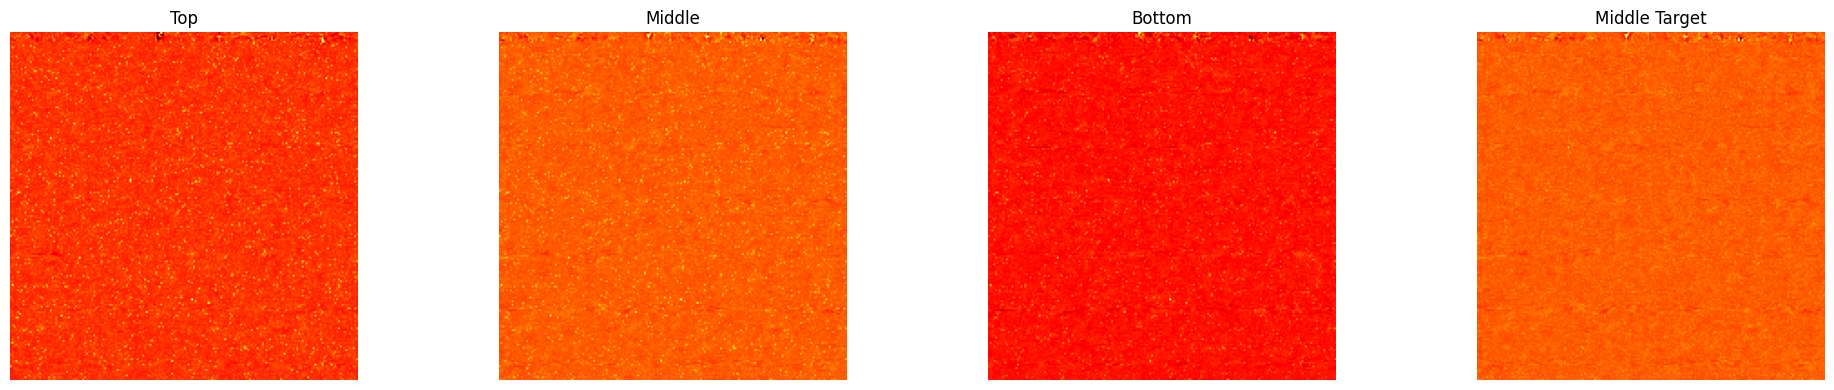

In [6]:
# example batch plot
num_batches_to_display = 5  # for example, show 3 batches

# Iterate through the DataLoader
for batch_idx, (top_slice, middle_slice, bottom_slice, middle_target) in enumerate(train_loader):
    
    # Print data details
    print(f"Batch {batch_idx + 1}")
    print(f"top_slice: {top_slice.dtype} {top_slice.shape} range:({torch.max(top_slice)},{torch.min(top_slice)}); mean:{torch.mean(top_slice)}; std:{torch.std(top_slice)}")
    print(f"middle_slice: {middle_slice.dtype} {middle_slice.shape} range:({torch.max(middle_slice)},{torch.min(middle_slice)}); mean:{torch.mean(middle_slice)}; std:{torch.std(middle_slice)}")
    print(f"bottom_slice: {bottom_slice.dtype} {bottom_slice.shape} range:({torch.max(bottom_slice)},{torch.min(bottom_slice)}); mean:{torch.mean(bottom_slice)}; std:{torch.std(bottom_slice)}")
    print(f"middle_target: {middle_target.dtype} {middle_target.shape} range:({torch.max(middle_target)},{torch.min(middle_target)}); mean:{torch.mean(middle_target)}; std:{torch.std(middle_target)}")

    # select the show baych index
    idx = -1

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))

    axes[0].imshow(top_slice[idx].squeeze().numpy(), cmap='hot')
    axes[0].set_title('Top')

    axes[1].imshow(middle_slice[idx].squeeze().numpy(), cmap='hot')
    axes[1].set_title('Middle')

    axes[2].imshow(bottom_slice[idx].squeeze().numpy(), cmap='hot')
    axes[2].set_title('Bottom')

    axes[3].imshow(middle_target[idx].squeeze().numpy(), cmap='hot')
    axes[3].set_title('Middle Target')

    
    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    # Break loop after displaying desired number of batches
    if batch_idx + 1 == num_batches_to_display:
        break


## 3.  define training modules 

In [7]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", dynamic_ncols=True)
    for top_slice, middle_slice, bottom_slice, middle_target in pbar:
        
        top_slice, middle_slice, bottom_slice, middle_target = top_slice.to(device), middle_slice.to(device), bottom_slice.to(device), middle_target.to(device)
        
        # Forward
        outputs = model(top_slice, middle_slice, bottom_slice)
        
        # Zero the gradient buffers
        optimizer.zero_grad()
        
        loss = criterion(outputs, middle_target)
        
        # Backward
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({"batch_loss": loss.item()})
    
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    return avg_loss



def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0 
    pbar = tqdm(val_loader, desc="Validating", dynamic_ncols=True)
    with torch.no_grad():
        for top_slice, middle_slice, bottom_slice, middle_target in pbar:
            
            top_slice, middle_slice, bottom_slice, middle_target = top_slice.to(device), middle_slice.to(device), bottom_slice.to(device), middle_target.to(device)
            
            outputs = model(top_slice, middle_slice, bottom_slice)
            
            loss = criterion(outputs, middle_target)
            total_loss += loss.item()
            pbar.set_postfix({"batch_loss": loss.item()})
    
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss

# @timer_decorator
# def test(model, test_loader, device):
#     model.eval()
#     preds = []
#     targets = []
#     pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
#     with torch.no_grad():
#         for top_slice, mask_middle_slice, bottom_slice, middle_slice in pbar:
#             top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
            
#             pred = model(top_slice, mask_middle_slice, bottom_slice)
#             preds.append(pred.cpu()) # predict
#             targets.append(middle_slice.cpu()) # original input data
            
#     return preds, targets
# def test(model, test_loader, device, original_shape):
#     # 初始化两个全0的tensor用于存放预测和目标
#     preds = torch.zeros(original_shape).to(device)
#     targets = torch.zeros(original_shape).to(device)

#     model.eval()
#     pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
#     with torch.no_grad():
#         for idx, (top_slice, mask_middle_slice, bottom_slice, middle_slices) in enumerate(pbar):
#             top_slice, mask_middle_slice, bottom_slice, middle_slices = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slices.to(device)
            
#             batch_preds = model(top_slice, mask_middle_slice, bottom_slice)
            
#             for b_idx, pred in enumerate(batch_preds):
#                 # 计算应该放置预测值和目标值的位置
#                 patience_idx = (idx * len(batch_preds) + b_idx) // (original_shape[1] * (original_shape[3] - 2))
#                 time_idx = ((idx * len(batch_preds) + b_idx) % (original_shape[1] * (original_shape[3] - 2))) // (original_shape[3] - 2)
#                 depth_idx = (idx * len(batch_preds) + b_idx) % (original_shape[3] - 2) + 1
                
#                 pred = pred.squeeze(0)
#                 middle_slice = middle_slices[b_idx].squeeze(0)
                
#                 preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
#                 targets[patience_idx, time_idx, :, depth_idx, :, :] = middle_slice

#     return preds.cpu(), targets.cpu()

def test(model, test_loader, device, dataset):
    model.eval()
    p, t, d = dataset.p, dataset.t, dataset.d
    # Note: d represents number of continuous slices after subtracting 2
    original_shape = (p, t, dataset.data_tensor.shape[2], d+2, dataset.data_tensor.shape[4], dataset.data_tensor.shape[5])

    preds = torch.zeros(original_shape).to(device)
    targets = torch.zeros(original_shape).to(device)

    pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
    with torch.no_grad():
        for idx, (top_slice, middle_slice, bottom_slice, middle_target) in enumerate(pbar):
            
            top_slice, middle_slice, bottom_slice, middle_target = top_slice.to(device), middle_slice.to(device), bottom_slice.to(device), middle_target.to(device)
            
            batch_preds = model(top_slice, middle_slice, bottom_slice)

            for b_idx, pred in enumerate(batch_preds):
                pred = pred.squeeze(0) # [channels, height, width]
                true_idx = idx*test_loader.batch_size + b_idx
                patience_idx = true_idx // (t * d)
                time_idx = (true_idx % (t * d)) // d
                depth_idx = true_idx % d + 1

                preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
                targets[patience_idx, time_idx, :, depth_idx, :, :] = middle_target[b_idx]

    return preds.cpu(), targets.cpu()




@timer_decorator
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, patience=5, save_path='path/to/your/directory'):
    best_loss = float('inf')
    early_stopping_counter = 0
    best_epoch = -1
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}, LR: {current_lr:.8e}")

        # Save the model with the best validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1  # 1-based counting for epoch
            best_save_path = os.path.join(save_path, f'best_model.pth')
            torch.save(best_model_wts, best_save_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement epoch:{epoch - patience}.")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [8]:
# define loss, optimizer, lr_scheduler

criterion = nn.L1Loss()
#criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## 4. process training

In [ ]:
trained_model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=10, save_path="./check_points")

Training:   0%|          | 0/828 [00:00<?, ?it/s]

Validating:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 1/200, Train Loss: 0.01224056, Validation Loss: 0.01014517, LR: 1.00000000e-03


Training:   0%|          | 0/828 [00:00<?, ?it/s]

Validating:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 2/200, Train Loss: 0.00461413, Validation Loss: 0.00921140, LR: 1.00000000e-03


Training:   0%|          | 0/828 [00:00<?, ?it/s]

Validating:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 3/200, Train Loss: 0.00322247, Validation Loss: 0.00581498, LR: 1.00000000e-03


Training:   0%|          | 0/828 [00:00<?, ?it/s]

Validating:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 4/200, Train Loss: 0.00296677, Validation Loss: 0.00675810, LR: 1.00000000e-03


Training:   0%|          | 0/828 [00:00<?, ?it/s]

Validating:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 5/200, Train Loss: 0.00261541, Validation Loss: 0.00545656, LR: 5.00000000e-04


Training:   0%|          | 0/828 [00:00<?, ?it/s]

Validating:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 6/200, Train Loss: 0.00137817, Validation Loss: 0.00647718, LR: 5.00000000e-04


Training:   0%|          | 0/828 [00:00<?, ?it/s]

Validating:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 7/200, Train Loss: 0.00144530, Validation Loss: 0.00738542, LR: 5.00000000e-04


Training:   0%|          | 0/828 [00:00<?, ?it/s]

Validating:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 8/200, Train Loss: 0.00140494, Validation Loss: 0.00742816, LR: 5.00000000e-04


Training:   0%|          | 0/828 [00:00<?, ?it/s]

Validating:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 9/200, Train Loss: 0.00144175, Validation Loss: 0.00611351, LR: 5.00000000e-04


Training:   0%|          | 0/828 [00:00<?, ?it/s]

Validating:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 10/200, Train Loss: 0.00136404, Validation Loss: 0.00569682, LR: 2.50000000e-04


Training:   0%|          | 0/828 [00:00<?, ?it/s]

## 5. process denoising

In [ ]:
# load best model
model.load_state_dict(torch.load('check_points/best_model.pth'))


In [ ]:
# denoising 
preds, targets = test(model, test_loader, device, test_dataset)

In [ ]:
denoised_data = preds[0].squeeze(1).numpy()
true_data = targets[0].squeeze(1).numpy()

print(f"denoised data: {denoised_data.dtype}; shape:{denoised_data.shape}; range:({np.min(denoised_data)},{np.max(denoised_data)}); mean:{np.mean(denoised_data)}; std:{np.std(denoised_data)}")
print(f"true_data data: {true_data.dtype}; shape:{true_data.shape}; range:({np.min(true_data)},{np.max(true_data)}); mean:{np.mean(true_data)}; std:{np.std(true_data)}")


# example plot
data_range_true = np.max(true_data[11, 38]) - np.min(true_data[11, 38])
data_range_denoised = np.max(denoised_data[11, 38]) - np.min(denoised_data[11, 38])
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data[11, 38], true_data[11, 38], data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.mean(brisque_values)}")

display_image_in_detail(denoised_data[15, 38], title='denoised')
display_image_in_detail(true_data[15, 38], title='true')

## 6. metrics evaluation

In [ ]:
data_range_true = np.max(true_data) - np.min(true_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, true_data, data_range=data_range)

psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan

print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

# Save denormalized denoised data into 16-bit DICOM files

In [ ]:
# denormalized denoised data
restored_data = restore_data(denoised_data, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")
display_4d_image(restored_data)

In [ ]:
# save denormalized denoised data as 16-bit gray-scale .DICOM files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/NAC/PT_20p 150_120 OSEM_poisson_0.50_batch'

save_4d_dicom(origin_dicom_folder, restored_data, output_folder)